# Quantum Monte Carlo

In [1]:
import random
import matplotlib.pyplot as plt
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import RYGate, QFT, GroverOperator, GlobalPhaseGate
from qiskit.quantum_info import Operator 
from qiskit.primitives import Sampler
from qiskit_algorithms import AmplitudeEstimation, EstimationProblem
from qiskit.visualization import circuit_drawer

Define a output of possible values

In [6]:
# number of qubits to define output_values
n = 3 

# probability of each outcome
p = [1/(2**n) for _ in range(2**n)]

# generate random output values in [0, 1]
output_values = [random.random() for _ in range(8)]

In [7]:
# predefined random output values in [0, 1]
output_values = [0.14540873108564567, 
                0.7176095194656084, 
                0.6997907514567188, 
                0.6605534896334453, 
                0.6658363318452754, 
                0.7469983777693564, 
                0.5506958884160964, 
                0.878205833802929
                ]

# calculate the true expectation and variance
mu = sum(output_values)/len(output_values)
var = sum([(value-mu)**2 for value in output_values])/len(output_values)
print(f'True expectation: {mu}')
print(f'True variance: {var}')

True expectation: 0.6331373654343845
True variance: 0.041387223395055954


**Standard Monte Carlo**

In [8]:
def standard_MC(output_values, p, M):
    """
    Perform standard Monte Carlo to estimate
    expected value.
    
    Parameters:
        output_values (list): List of possible output values.
        p (list): List of probabilities for each output value.
        M (int): Number of samples.
    
    Returns:
        tuple: Sample mean and sample standard deviation.
    """
    samples = random.choices(output_values, weights=p, k=M)
    sample_mean =  sum(samples)/M
    sample_std = (sum((sample-sample_mean)**2 for sample in samples)/M)**0.5 
    return sample_mean, sample_std

Run standard Monte Carlo experiments

In [199]:
# define list of sample sizes for Monte Carlo simulation
M_list = [2**(i+1) for i in range(25)]

# lists to store results of estimations and errors
estimations = []
errors_real = []
errors_pred = []

# (1- 2*alpha) confidence interval
ci_lower = []
ci_upper = []

# perform Monte Carlo estimations for different sample sizes
for M in M_list:
    sample_mean, sample_std = standard_MC(output_values, p, M)
    estimations.append(sample_mean)
    errors_real.append(abs(sample_mean-mu)/mu)  
    errors_pred.append((var/M)**0.5)
    ci_lower.append(sample_mean-1.645*(sample_std/M**0.5))
    ci_upper.append(sample_mean+1.645*(sample_std/M**0.5))


Plot convergence of relative error

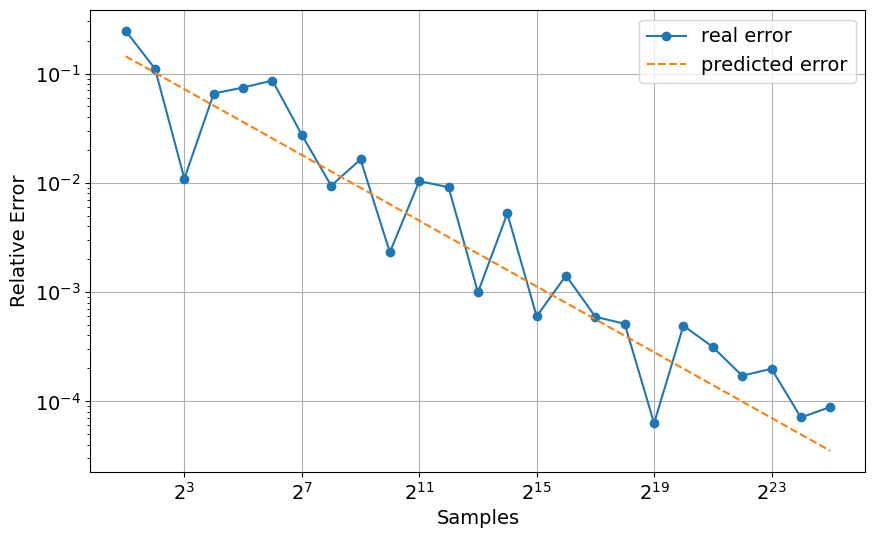

In [200]:
plt.figure(figsize=(10, 6))
plt.plot(M_list, errors_real, marker='o', linestyle='-', label='real error')
plt.plot(M_list, errors_pred, linestyle='--', label='predicted error')
plt.legend(fontsize=14)
plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Relative Error', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.show()

Plot convergence of estimation

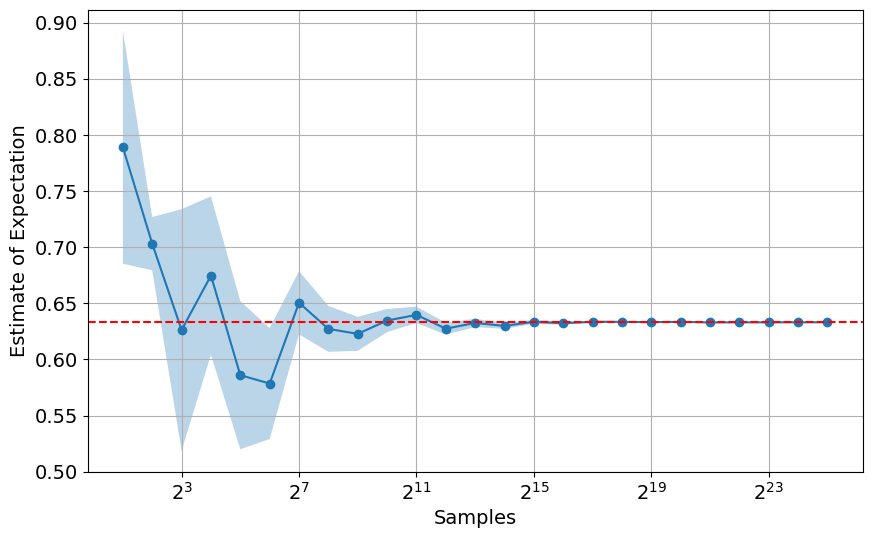

In [201]:
plt.figure(figsize=(10, 6))
plt.plot(M_list, estimations, marker='o', linestyle='-')
plt.fill_between(M_list, ci_lower, ci_upper, alpha=0.3)
plt.axhline(y=mu, color='r', linestyle='--')
plt.xscale('log', base=2)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Estimate of Expectation', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.show()

**Quantum Monte Carlo**

In [16]:
# mapping between bits and output value
bit_strings = [format(i, f'0{n}b') for i in range(2**n)]
mapping = dict(zip(bit_strings, output_values))
mapping

{'000': 0.14540873108564567,
 '001': 0.7176095194656084,
 '010': 0.6997907514567188,
 '011': 0.6605534896334453,
 '100': 0.6658363318452754,
 '101': 0.7469983777693564,
 '110': 0.5506958884160964,
 '111': 0.878205833802929}

State preperation

In [17]:
def state_function(state, y, qc):
    """
    Apply the state function for the given state and value y.
    
    Parameters:
        state (str): Bitstring representing the state.
        y (float): Output value associated with the state.
        qc (QuantumCircuit): Quantum circuit to apply the state function on.
    """
   
    for i in range(len(state)):
        if state[i] == '0':
            qc.x([len(state)-i])
    
    theta = math.asin(y**0.5)*2    
    rot = RYGate(theta).control(len(state))
    qc.append(rot, [1, 2, 3, 0])
    
    for i in range(len(state)):
        if state[i] == '0':
            qc.x([len(state)-i]) 

Visualize state preperation

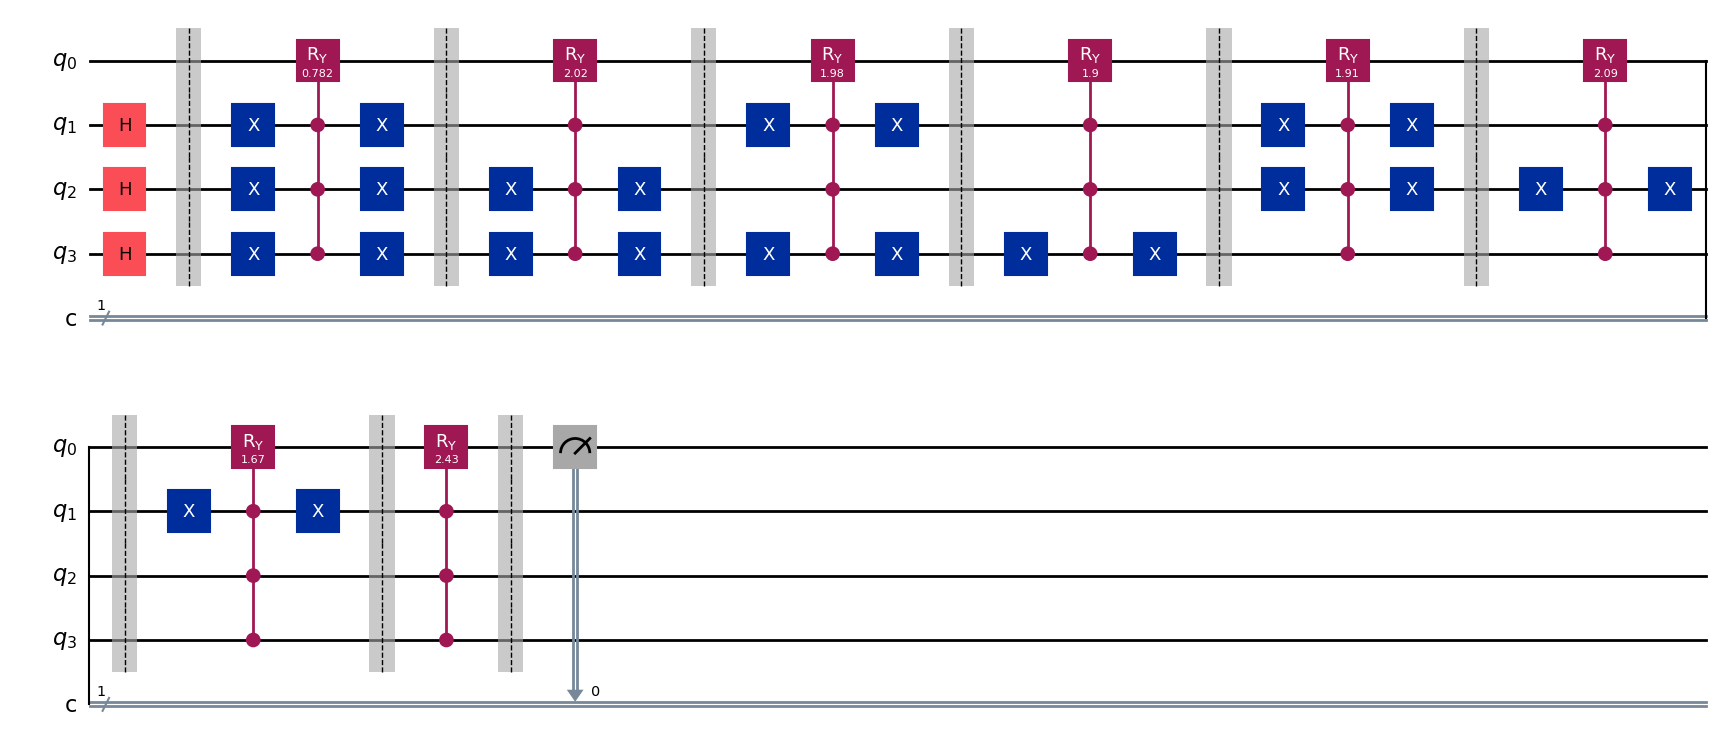

In [113]:
# initialize quantum and classical registers
qr = QuantumRegister(n+1, name='q')
cr = ClassicalRegister(1, name='c')
qc = QuantumCircuit(qr,cr)

# create uniform probability distribution
qc.h([(x+1) for x in range(n)])

# apply state function
for state in mapping:
    qc.barrier()
    state_function(state=state, y=mapping[state], qc=qc)
qc.barrier()    

qc.measure([0], [0])


circuit_drawer(qc, output='mpl', scale=1, )

Run state preperation

In [114]:
simulator = Aer.get_backend('qasm_simulator')
qc_transpiled = transpile(qc, simulator, optimization_level=1)
job = simulator.run(qc_transpiled, shots=100000)
job_result = job.result() 
counts = job_result.get_counts(qc_transpiled)
counts

{'1': 63161, '0': 36839}

Compare measurements from state preperation with standard MC

In [127]:
def quantum_MC(qc, M):
    """
    Perform measurements from state preparation.
    
    Parameters:
        qc (QuantumCircuit): Quantum circuit to run.
        M (int): Number of samples.
    
    Returns:
        float: estimated mean.
    """
    simulator = Aer.get_backend('qasm_simulator')
    qc_transpiled = transpile(qc, simulator, optimization_level=1)
    job = simulator.run(qc_transpiled, shots=M)
    job_result = job.result() 
    counts = job_result.get_counts(qc_transpiled)
    res = counts.get('1', 0)/sum(counts.values())    
    return res


# perform quantum measurements for different sample sizes
M_list = [2**(i+1) for i in range(25)]

res_quantum = []
res_standard = []
pred = []


for M in M_list:
    mu_estimate = quantum_MC(qc=qc, M=M)
    res_quantum.append(abs(mu_estimate-mu)/mu)
    
    mu_estimate = standard_MC(output_values=output_values, p=p, M=M)[0]
    res_standard.append(abs(mu_estimate-mu)/mu)
   
    pred.append(1/M**0.5)
    


Plot comparison of relative error

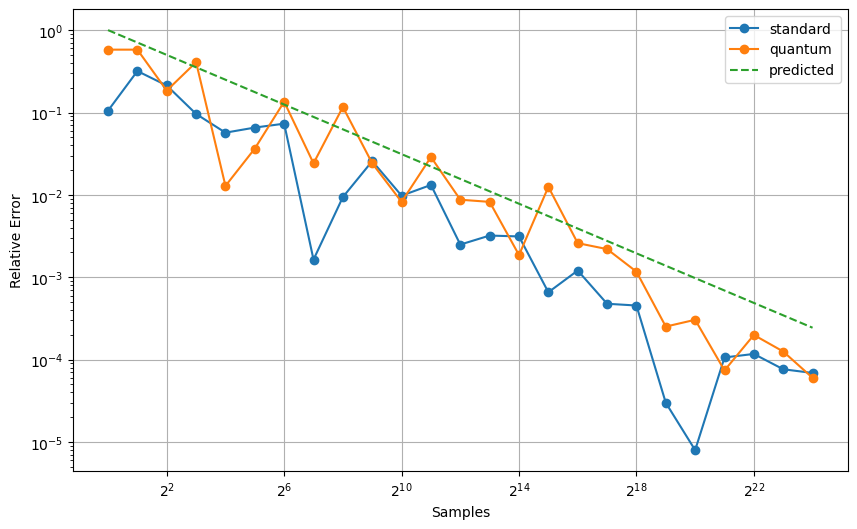

In [128]:
plt.figure(figsize=(10, 6))
plt.plot(M_list, res_standard, marker='o', linestyle='-', label='standard')
plt.plot(M_list, res_quantum, marker='o', linestyle='-', label='quantum')
plt.plot(M_list, pred, linestyle='--', label='predicted')
plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.xlabel('Samples')
plt.ylabel('Relative Error')
plt.grid(True)
plt.legend()
plt.show()

Introduce amplitude estimation instead of performing measurements

Create state preparation gate

In [129]:
# initialize quantumm circuit
qr = QuantumRegister(n+1)
qc = QuantumCircuit(qr)

# create uniform probability distribution
qc.h([(x+1) for x in range(n)])

# apply state function
for state in mapping:
    state_function(state=state, y=mapping[state], qc=qc)

# state preperation gates
A = qc.to_gate(label='A')
A_inv = qc.inverse().to_gate(label='A_inv')

Create Grover operator

In [130]:
def U_operator(qc, n, A, A_inv):
    """
    Apply the zero reflection operator for amplitude estimation.
    
    Parameters:
        qc (QuantumCircuit): Quantum circuit to apply the operator on.
        n (int): Number of qubits.
        A (Gate): State preparation gate.
        A_inv (Gate): Inverse of the state preparation gate.
    """ 

    qc.append(A_inv, [x for x in range(n+1)])

    for i in range(n+1):
        qc.x([i])
        
    qc.h([n])
    qc.mcx(control_qubits=list(range(0,n)), target_qubit=[n])
    qc.h([n])
 
    for i in range(n+1):
        qc.x([i])
    qc.append(A, [0, 1, 2, 3])


def V_operator(qc):
    """
    Apply the phase oracle operator for amplitude estimation.
    
    Parameters:
        qc (QuantumCircuit): Quantum circuit to apply the operator on.
    """

    qc.h([0])
    qc.x([0])
    qc.h([0])

def Q_operator(power, n):
    """
    Create the Grover operator for amplitude estimation.
    
    Parameters:
        power (int): Power of the operator.
        n (int): Number of qubits.
    
    Returns:
        Gate: Controlled-Q gate.
    """
    qr = QuantumRegister(n+1)
    qc = QuantumCircuit(qr, name=f'Q_2^{power}')
    
    for _ in range(2**power):     
        qc.append(GlobalPhaseGate(math.pi))
        V_operator(qc)
        U_operator(qc, n, A, A_inv)
        
    return qc.to_gate().control()     

Plot zero-reflection circuit

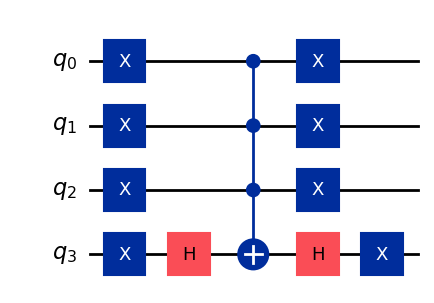

In [131]:
n = 3
qr = QuantumRegister(n+1, name='q')
qc = QuantumCircuit(qr)

#qc.append(GlobalPhaseGate(math.pi))
for i in range(n+1):
    qc.x([i])
    
qc.h([n])
qc.mcx(control_qubits=list(range(0,n)), target_qubit=[n])
qc.h([n])

for i in range(n+1):
    qc.x([i])

circuit_drawer(qc, output='mpl')

Amplitude estimation circuit

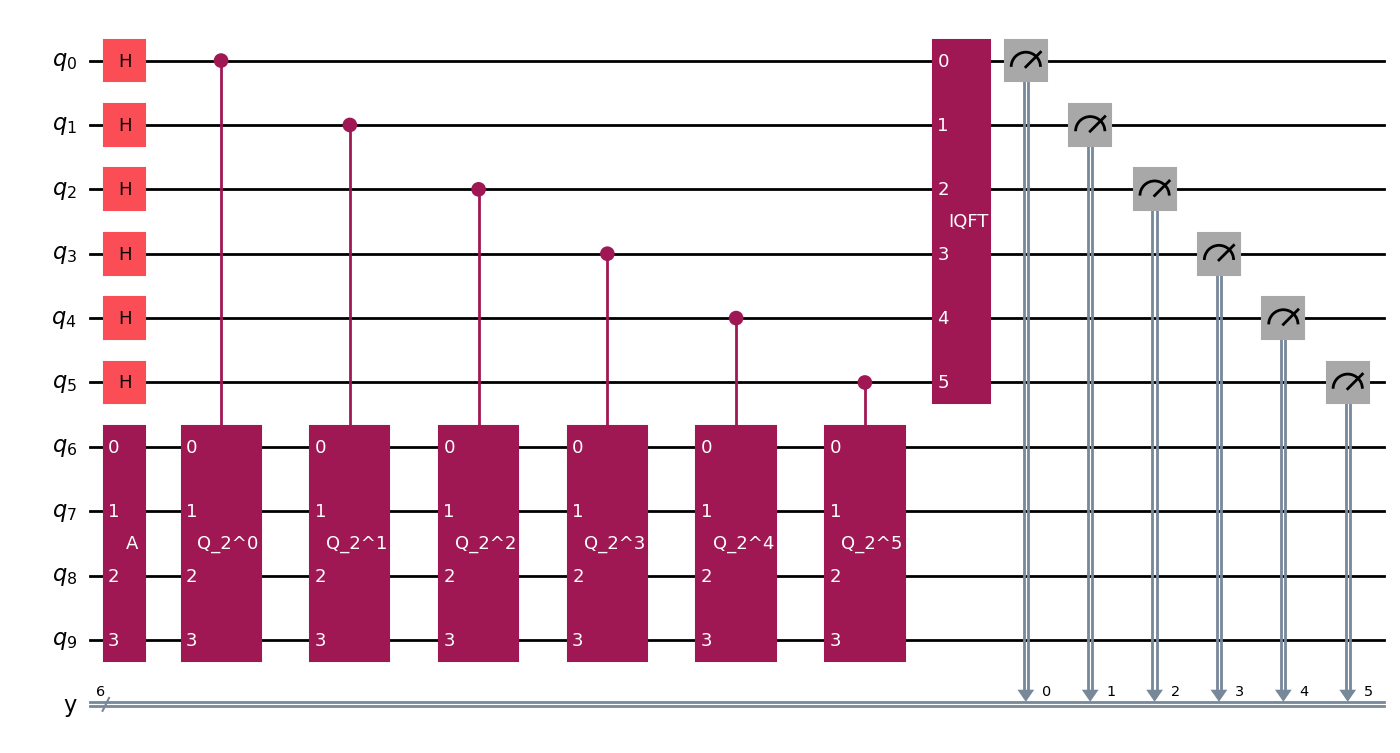

In [132]:
m = 6 # ancilla qubits

# initialize quantum circuit
qr = QuantumRegister(n+1+m, name='q')
cr = ClassicalRegister(m, name='y')
qc = QuantumCircuit(qr,cr)

# state preparation
qc.h([i for i in range(m)])
qc.append(A, [i+m for i in range(4)])

# Grover operations
for i in range(m):
    indices = [i]
    indices+=list(range(m, qr.size))
    qc.append(Q_operator(power=i, n=n), indices)

# quantum Fourier transform
qc.append(QFT(m).inverse(), qr[0:m])

# measurement 
qc.measure(qr[0:m], cr)
    
circuit_drawer(qc, output='mpl')

In [171]:
# run the quantum circuit for amplitude estimation
sampler = Sampler()
job = sampler.run(qc, shots=3000, seed=42)
job_result = job.result()
counts = job_result.quasi_dists[0]
most_frequent = max(counts, key=counts.get)
int_value = most_frequent

Plot probability distribution of outcomes of measurement

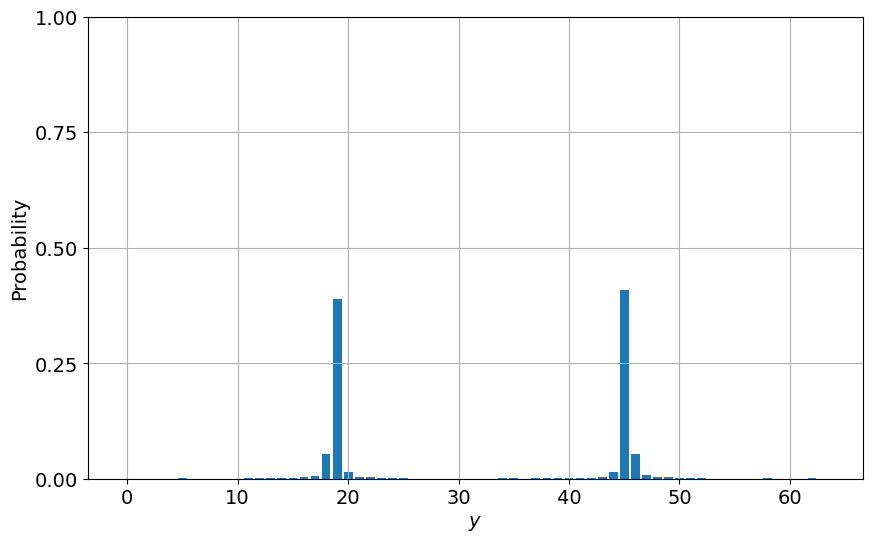

In [160]:
gridpoints = list(counts.keys())
probabilities = list(counts.values())
plt.figure(figsize=(10, 6))
plt.bar(gridpoints, probabilities) 
plt.xticks(size=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=14)
plt.ylabel("Probability", size=14)
plt.xlabel(r"$y$", size=14)
plt.ylim((0, 1))
plt.grid()
plt.show()

Calculate and plot unique amplitudes and their probabilities

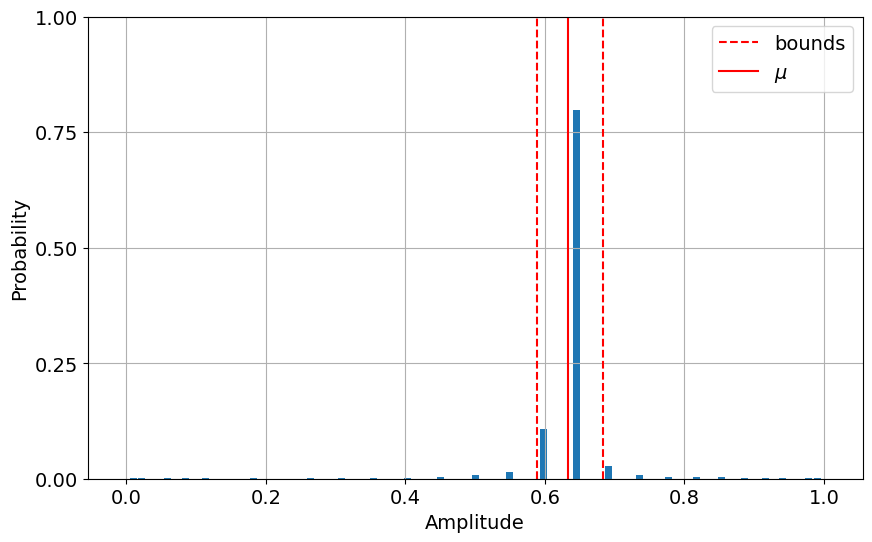

In [148]:
amplitudes = [round(math.sin(math.pi*int_value/(2**m))**2, 6) for int_value in gridpoints]
probabilities = list(counts.values())


amplitudes_unique = list(set(amplitudes))
probabilities_unique = []


for x in amplitudes_unique:
    prob = 0 
    for i, y in enumerate(amplitudes):
        if x==y:
             prob += probabilities[i]
    probabilities_unique.append(prob)

lower_bound = mu - 2*math.pi*(mu*(1-mu))**0.5/2**m + math.pi**2/(2**m)**2
upper_bound = mu + 2*math.pi*(mu*(1-mu))**0.5/2**m + math.pi**2/(2**m)**2

plt.figure(figsize=(10, 6))
plt.bar(amplitudes_unique, probabilities_unique, width=0.01) 
plt.xticks(size=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=14)
plt.ylabel("Probability", size=14)
plt.xlabel('Amplitude', size=14)
plt.ylim((0, 1))
plt.axvline(x=lower_bound, color='r', linestyle='--', label='bounds')
plt.axvline(x=upper_bound, color='r', linestyle='--')
plt.axvline(x=mu, color='r', linestyle='-', label=r'$\mu$')
plt.legend(fontsize=14)
plt.grid()
plt.show()

In [176]:
# estimated value of theta 
print(math.pi*int_value/(2**m))

# estimated applitude
print(math.sin(math.pi*int_value/(2**m))**2)

2.2089323345553233
0.6451423386272312


Check second eigenstate

In [177]:
counts_2 = counts
counts_2.pop(most_frequent)
most_frequent_2 = max(counts_2, key=counts.get)
int_value_2 = most_frequent_2
int_value_2

# estimated value of theta 
print(math.pi*int_value_2/(2**m))

# estimated applitude
print(math.sin(math.pi*int_value_2/(2**m))**2)

0.9326603190344698
0.645142338627231


Amplitude esimation with built-in Grover operator 

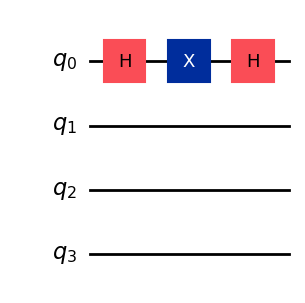

In [178]:
# create oracle
qr = QuantumRegister(n+1, name='q')
oracle = QuantumCircuit(qr)
V_operator(oracle)
oracle.draw()

circuit_drawer(oracle, output='mpl', scale=1)

In [183]:
# create state preperation
qr = QuantumRegister(n+1)
state_prearation = QuantumCircuit(qr)

# create uniform probability distribution
state_prearation.h([x+1 for x in range(n)]) 

# apply state function
for state in mapping:
    state_function(state=state, y=mapping[state], qc=state_prearation)


In [184]:
# create grover operator 
Q = GroverOperator(oracle=oracle, 
                   state_preparation=state_prearation, 
                   zero_reflection=None, 
                   reflection_qubits=None, 
                   insert_barriers=False, 
                   mcx_mode='noancilla', 
                   name='Q')

In [187]:
# prepare amplitude estimation
sampler = Sampler()
ae = AmplitudeEstimation(
    num_eval_qubits=5,  # the number of evaluation qubits specifies circuit width and accuracy
    sampler=sampler,
)

problem = EstimationProblem(
    state_preparation=state_prearation,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

# run amplitude estimation
ae_result = ae.estimate(problem)
ae_result.estimation

0.5975452

Run quantum Monte Carlo experiments

In [196]:
def quantum_MC(A, Q, m):
    """
    Perform quantum Monte Carlo estimation using amplitude estimation.

    Parameters:
    A (QuantumCircuit): State preparation circuit (A operator).
    Q (QuantumCircuit): Grover operator (Q operator).
    m (int): Number of evaluation qubits

    Returns:
    float: Estimated amplitude value.
    """

    sampler = Sampler()
    
    ae = AmplitudeEstimation(
        num_eval_qubits=m,  # the number of evaluation qubits specifies circuit width and accuracy
        sampler=sampler,
    )  
    
    problem = EstimationProblem(
        state_preparation=A,  # A operator
        grover_operator=Q,  # Q operator
        objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )

    ae_result = ae.estimate(problem)
    
    return ae_result.estimation

# list of evaluation qubits
m_list = [i+1 for i in range(11)]

# lists to store amplitude estimation results and errors
ae_estimations = []
ae_errors_real = []
ae_errors_pred = []

# perform amplitude estimation for each value of m in m_list
for m in m_list:
    # estimate the amplitude using the quantum_MC function
    estimation = quantum_MC(A=state_prearation, Q=Q, m=m)
    ae_estimations.append(estimation)

    # calculate the real error and append to the list
    ae_errors_real.append(abs(estimation-mu)/mu)

    # calculate the predicted error and append to the list 
    ae_errors_pred.append(1/((2**(m))))
    print(m, estimation)

1 1.0
2 0.5
3 0.5
4 0.6913417
5 0.5975452
6 0.6451423
7 0.6214901
8 0.6333564
9 0.6333564
10 0.6333564
11 0.6333564


Plot comparison of error

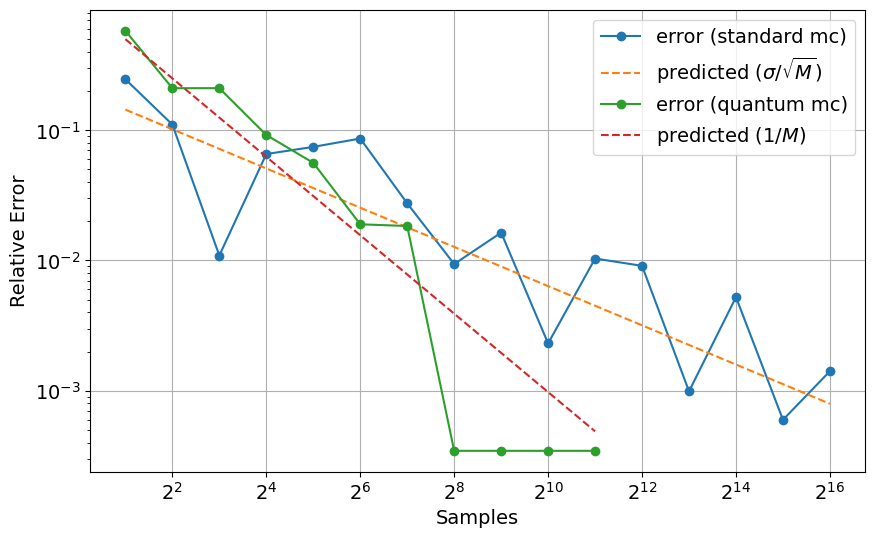

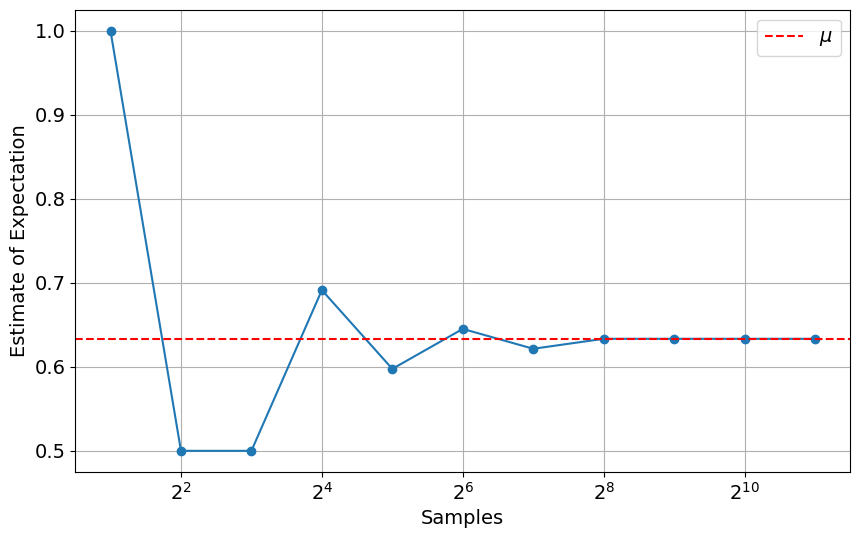

In [204]:
M_list = [2**(i+1) for i in range(25)]

plt.figure(figsize=(10, 6))
plt.plot(M_list[0:len(m_list)+5], errors_real[0:len(m_list)+5], marker='o', linestyle='-', label='error (standard mc)')
plt.plot(M_list[0:len(m_list)+5], errors_pred[0:len(m_list)+5], linestyle='--', label=r'predicted ($\sigma/\sqrt{M}$)')

plt.plot(M_list[0:len(m_list)], ae_errors_real, marker='o', linestyle='-', label='error (quantum mc)')
plt.plot(M_list[0:len(m_list)], ae_errors_pred, linestyle='--', label=r'predicted ($1/M$)')


plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Relative Error', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(M_list[0:len(m_list)], ae_estimations, marker='o', linestyle='-')
plt.axhline(y=mu, color='r', linestyle='--', label=r'$\mu$')
plt.xscale('log', base=2)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Estimate of Expectation', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

Variations of the amplitude estimation

In [206]:
from qiskit_algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    sampler=sampler,
)
iae_result = iae.estimate(problem)

print("Estimate:", iae_result.estimation)

Estimate: 0.6331373654343857


In [207]:
from qiskit_algorithms import MaximumLikelihoodAmplitudeEstimation

mlae = MaximumLikelihoodAmplitudeEstimation(
    evaluation_schedule=1,  # log2 of the maximal Grover power
    sampler=sampler,
)
mlae_result = mlae.estimate(problem)

print("Estimate:", mlae_result.estimation)

Estimate: 0.6331285897406929
